# Lab 4-6: Mixture Models+Model orden selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before November 21 at 23:59 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [44]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
#sns.set_context('poster')
#sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
import time
import sklearn
import math

We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [271]:
class my_GMM():
    
    def __init__(self, k, init_strat="random", bin_strat="hard", tol=1e-2, itermax=50):
        '''
        Parameters:
        k: integer
            number of components
        tol: float
            convergence tolerance
       
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k_ = k
        self.tol_ = tol
        self.itermax_ = itermax
        self.init_strat_ = init_strat
        self.bin_strat_ = bin_strat
        
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
        self.history = {}
        
    def gauss_pdf(self, X, mu, Sigma):
        """
        Computes the PDF of a Gaussian distribution of parameters Sigma and mu,
        evaluated in every point of X and every cluster
        
        Parameters:
        -----------
        X: (n, p) np.array
            Points of evaluation
        
        mu: (k, p) np.array
            Estimators of the mean
            
        Sigma: (k, p, p) np.array
            Variance matrix estimators
        
        Returns:
        -----
        (n, k) array: Evaluation of the PDF
        """
        n, p = X.shape
        k,_ = mu.shape
        exp = np.zeros((n, k))
        det = np.zeros((k,))

        Sinv = np.array([np.linalg.inv(Sigma[j]) for j in range(k)])
        Det = np.array([np.linalg.det(Sigma[j]) for j in range(k)])
        Dev = np.array([X-mu[j] for j in range(k)])

        for j in range(k):
            exp[:, j] = np.diag(Dev[j]@Sinv[j]@Dev[j].T)
        return np.exp(
            -0.5 * np.log(2*np.pi*Det + 1e-6)
            -0.5 * exp
        )
    
    def fit_(self, X, alpha0, mu0, Sigma0):
        self.alpha_, self.mu_, self.Sigma_ = alpha0, mu0, Sigma0
        self.has_converged = False
        self.history = {"cpm": [], "alpha": [], "mu": [], "Sigma": []}
        
        itr = 0
        while not self.has_converged and itr < self.itermax_:
            itr += 1
            # E-step: compute conditional probability matrix
            self.cond_prob_ = self.compute_proba(X=X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_)
            
            self.history["cpm"].append(self.cond_prob_)
            self.history["alpha"].append(self.alpha_)
            self.history["mu"].append(self.mu_)
            self.history["Sigma"].append(self.Sigma_)
            
            # M-step: update parameters estimators
            new_alpha = self.update_alpha(cpm=self.cond_prob_)
            new_mu = self.update_mu(X=X, cpm=self.cond_prob_, alpha=new_alpha)
            new_Sigma = self.update_Sigma(X=X, cpm=self.cond_prob_, alpha=new_alpha, mu=new_mu)
            
            old_params = (self.alpha_, self.mu_, self.Sigma_)
            new_params = (new_alpha, new_mu, new_Sigma)
            
            self.has_converged = self.evaluate_convergence(X, old_params=old_params, new_params=new_params)
            
            self.alpha_ = new_alpha
            self.mu_ = new_mu
            self.Sigma_ = new_Sigma
        
        self.labels_ = self.predict(X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_)
        return self
        
        
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """    
        
        # Initialize parameters estimators
        init_params = self.init_params(X, self.k_)
        
        return self.fit_(X, *init_params)
        
    def predict(self, X, alpha, mu, Sigma):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """ 
        n= X.shape[0]
        cpm = self.compute_proba(X=X, alpha=alpha, mu=mu, Sigma=Sigma)
        labels = np.argmax(cpm, axis=1)
        return labels
    
    def evaluate_convergence(self, X, old_params, new_params):
        """Returns wether the algorithm has converged
        """
        return abs(self.log_likelihood(X, *old_params) - self.log_likelihood(X, *new_params)) <= self.tol_
        
    def compute_proba(self, X, alpha, mu, Sigma):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n, p = X.shape
        k = self.k_
        alpha = alpha.reshape(-1,1)
        PDFs = self.gauss_pdf(X, mu, Sigma)
        cpm = np.exp(
            np.log(np.repeat(alpha.T, n, axis=0) + 1e-6) 
            + np.log(PDFs + 1e-6)
            - np.log(np.repeat(PDFs@alpha, k, axis=1) + 1e-6)
        )
        return cpm
    
    def init_params(self, X, K):
        """Initialize parameters estimators
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        K: int
            Number of classes / clusters
        
        Returns:
        -----
        ((k,) np.array, (k, p) np.array, (k, p, p) np.array) tuple
            Tuple of 3 np.arrays: (alpha0, mu0, Sigma0)
        """        
        n = X.shape[0]
        p = X.shape[1]
        
        from sklearn.cluster import KMeans
        k_means = KMeans(n_clusters=K).fit(X)
        X_labels = k_means.labels_
        
        mu0 = k_means.cluster_centers_
        Sigma0 = []
        alpha0 = []
        
        for k, count in zip(*np.unique(X_labels, return_counts=True)):
            X_k = np.array([X[i] for i in range(n) if X_labels[i] == k])
            Sigma0.append(np.cov(X_k.T) + 1e-3 * np.eye(p))
            alpha0.append(count/n)
        Sigma0 = np.array(Sigma0)
        alpha0 = np.array(alpha0)
        
        return (alpha0, mu0, Sigma0)
    
    def update_alpha(self, cpm):
        """Returns the updated version of alpha (cluster proportion estimators)
        
        Parameters:
        -----------
        cpm: (n, k) np.array
            Conditional probability matrix

        Returns:
        -----
        (k,) np.array
            The new estimators for cluster proportion
        """
        new_alpha = np.mean(cpm, axis=0)
        return new_alpha
    
    def update_mu(self, X, cpm, alpha):
        """Returns the updated version of mu (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        Returns:
        -----
        (k, p) np.array
            The new estimators for clusters' means
        """
        n = X.shape[0]
        k = cpm.shape[1]   
        p = X.shape[1]
        new_mu = cpm.T@X
        np.divide(new_mu, np.repeat(n * alpha.reshape(-1,1), p, axis=1), out=new_mu)
        return new_mu

    def update_Sigma(self, X, cpm, alpha, mu):
        """Returns the updated version of Sigma (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
        
        Returns:
        -----
        (k, p, p) np.array
            The new estimators for clusters' variances
        """
        n = X.shape[0]
        k = cpm.shape[1]
        p = X.shape[1]
        
        new_Sigma = np.zeros(shape=(k, p, p))
        
        for j in range(k):
            dev = X - mu[j]
            c_dev = np.multiply(np.repeat(cpm[:,j].reshape(-1,1), p, axis=1), dev)
            new_Sigma[j] = (c_dev.T @ dev) / (n * alpha[j])
        return new_Sigma
    
    def log_likelihood(self, X, alpha, mu, Sigma):
        """Returns whether the algorithm has converged
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
            
        Sigma: (k, p, p) np.array
            Current estimators for clusters' variances
        
        Returns:
        -----
        float
            log-likelihood for the given parameters
        """
        l = 0
        n = X.shape[0]
        k = alpha.shape[0]
        alpha = alpha.reshape(-1,1)
        PDFs = self.gauss_pdf(X, mu, Sigma)
        return np.ones((1,n))@(PDFs@alpha)

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

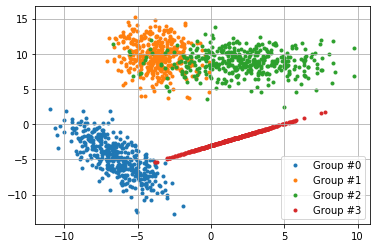

In [87]:
X = []

for _ in range(4):
    mu = np.random.uniform(-10,10, (2,))
    sigma = np.random.uniform(-3,3, (2,2))
    sigma = sigma.T@sigma
    pts = []
    for _ in range(400):
        pts.append(np.random.multivariate_normal(mean=mu, cov=sigma))
    X.append(np.array(pts))

for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], marker='.', label="Group #{}".format(i))
plt.legend()
plt.grid()
plt.show()

In [88]:
data = np.concatenate(X)

In [89]:
gmm = my_GMM(k=4)
start = time.time()
gmm.fit(data)
end = time.time()
print("Has converged:", gmm.has_converged, "exec time {:.2f} ms".format((end-start)*1e3))

Has converged: [[ True]] exec time 534.44 ms


In [177]:
range(8)[3]

3

In [180]:
def gmm_accuracy_mapping(X, gmm):
    """
    Computes the accuracy of our model and also returns the mapping of the labels.
    """
    acc = 0
    mapping = {}
    data = np.concatenate(X)
    
    if len(X)==np.unique(gmm.labels_).shape[0]:
        for gmm_label in np.unique(gmm.labels_):
            data_cluster = np.array([data[j] for j in range(data.shape[0]) if gmm.labels_[j] == gmm_label])

            search_count = np.array([0 for true_label in range(len(X))])
            for pt in data_cluster:
                for true_label in range(len(X)):
                    search_count[true_label] += 1 if pt in X[true_label] else 0
            mapping[gmm_label] = np.argmax(search_count)
            acc += np.max(search_count)

        acc /= float(len(gmm.labels_))

        return acc, mapping
    
    else:
        if len(X) < len(np.unique(gmm.labels_)):
            mapping = {k:len(np.unique(gmm.labels_)) - 1 for k in range(len(np.unique(gmm.labels_)))}
        reverse_mapping = {}
        pts_concerned = {k:0 for k in range(len(X))}
        
        for gmm_label in np.unique(gmm.labels_):
            data_cluster = np.array([data[j] for j in range(data.shape[0]) if gmm.labels_[j] == gmm_label])

            search_count = np.array([0 for true_label in range(len(X))])
            for pt in data_cluster:
                for true_label in range(len(X)):
                    search_count[true_label] += 1 if pt in X[true_label] else 0
            true_label = np.argmax(search_count)
            if true_label not in mapping.values():
                mapping[gmm_label] = true_label # map the gmm_label to the true_label
                reverse_mapping[true_label] = gmm_label # record the reverse link
                pts_concerned[true_label] = search_count[true_label] # memory of the number of points concerned by this mapping
            
            elif search_count[true_label] > pts_concerned[true_label]:
                mapping[reverse_mapping[true_label]] = len(np.unique(gmm.labels_)) - 1 # assign the old one back to its original value
                mapping[gmm_label] = true_label # map the gmm_label to the true_label
                reverse_mapping[true_label] = gmm_label # record the reverse link
                pts_concerned[true_label] = search_count[true_label] # memory of the number of points concerned by this mapping
        
        acc = np.sum(list(pts_concerned.values()))
        acc /= float(len(gmm.labels_))
        
        idx = 1
        for cluster in mapping.keys():
            if mapping[cluster] >= len(X):
                mapping[cluster] = len(np.unique(gmm.labels_)) - idx
                idx += 1

        return acc, mapping

In [163]:
def visualize_gmm(X, gmm1, title1, gmm2=None, title2=''):
    """
    Function to plot the ground truth and the method of mixture models.
    """
    data = np.concatenate(X)
    
    plt.figure(figsize=(16,4))

    plt.subplot(121)
    acc1, mapping1 = gmm_accuracy_mapping(X, gmm1)
    for index in range(len(gmm1.labels_)):
        gmm1.labels_[index] = mapping1[gmm1.labels_[index]]
    for label in np.unique(gmm1.labels_):
        data_i = np.array([data[j] for j in range(data.shape[0]) if gmm1.labels_[j] == label])
        plt.scatter(data_i.T[0], data_i.T[1], marker='.', label="Cluster #{}".format(label))
    plt.title(title1 + '\naccuracy = {}'.format(acc1))
    plt.legend()
    plt.grid()

    plt.subplot(122)
    if gmm2==None:
        for i, pts in enumerate(X):
            plt.scatter(pts.T[0], pts.T[1], marker='.', label="Group #{}".format(i))
        plt.title('Ground truth')
    else:
        acc2, mapping2 = gmm_accuracy_mapping(X, gmm2)
        for index in range(len(gmm2.labels_)):
            gmm2.labels_[index] = mapping2[gmm2.labels_[index]]
        for label in np.unique(gmm2.labels_):
            data_i = np.array([data[j] for j in range(data.shape[0]) if gmm2.labels_[j] == label])
            plt.scatter(data_i.T[0], data_i.T[1], marker='.', label="Cluster #{}".format(label))
        plt.title(title2 + '\naccuracy = {}'.format(acc2))
    plt.legend()
    plt.grid()
    plt.show()

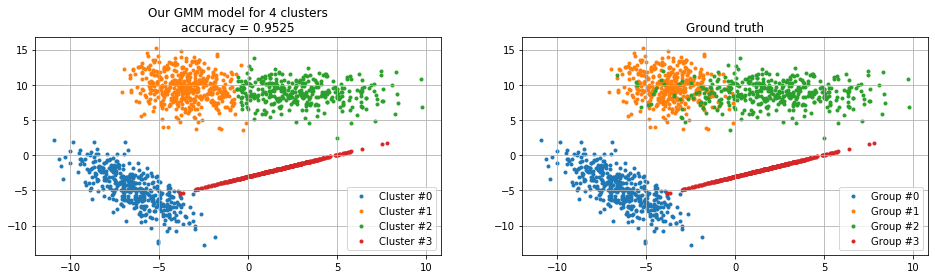

In [164]:
visualize_gmm(X, gmm, 'Our GMM model for 4 clusters')

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

### Second Part
 
- Implement the information criterions from the lecture (AIC, BIC, etc.) to select the number of clusters:

In [82]:
def AIC(C, X):
    """
    returns a tuple (model, AIC_value)
    """
    gmm = my_GMM(k=C)
    gmm.fit(X)
    # Compute the number of parameters of our model :
    p = X.shape[1]
    M = C * (1 + p + p*(p+1)/2) - 1 
    # because the Cth element of alpha is deduced by the others, and sigma is symmetric
    return gmm, gmm.log_likelihood(X, gmm.alpha_, gmm.mu_, gmm.Sigma_) - M

def BIC(C, X):
    """
    returns a tuple (model, BIC_value)
    """
    gmm = my_GMM(k=C)
    gmm.fit(X)
    # Compute the number of parameters of our model :
    N = X.shape[0]
    p = X.shape[1]
    M = C * (1 + p + p*(p+1)/2) - 1 
    # because the Cth element of alpha is deduced by the others, and sigma is symmetric 
    return gmm, gmm.log_likelihood(X, gmm.alpha_, gmm.mu_, gmm.Sigma_) - M*N/2

In [91]:
AIC_scores = []
BIC_scores = []
for C in range(1,8):
    begin = time.time()
    AIC_scores.append(AIC(C, data)[1][0,0])
    stop_1 = time.time()
    BIC_scores.append(BIC(C, data)[1][0,0])
    end = time.time()
    print("AIC, M={} takes {} seconds to converge.".format(C,stop_1-begin))
    print("BIC, M={} takes {} seconds to converge.".format(C,end-stop_1))    

AIC, M=1 takes 0.06908226013183594 seconds to converge.
BIC, M=1 takes 0.06930303573608398 seconds to converge.
AIC, M=2 takes 0.17208600044250488 seconds to converge.
BIC, M=2 takes 0.16028213500976562 seconds to converge.
AIC, M=3 takes 0.5894861221313477 seconds to converge.
BIC, M=3 takes 0.536484956741333 seconds to converge.
AIC, M=4 takes 0.5063319206237793 seconds to converge.
BIC, M=4 takes 0.5079920291900635 seconds to converge.
AIC, M=5 takes 3.5003979206085205 seconds to converge.
BIC, M=5 takes 3.285449266433716 seconds to converge.
AIC, M=6 takes 5.416083097457886 seconds to converge.
BIC, M=6 takes 5.331383943557739 seconds to converge.
AIC, M=7 takes 8.277623176574707 seconds to converge.
BIC, M=7 takes 8.153589725494385 seconds to converge.


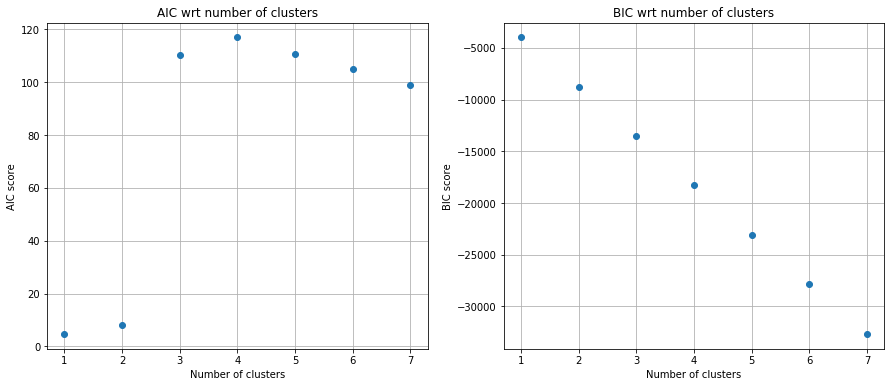

In [92]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(range(1,8), AIC_scores, linestyle='', marker='o')
plt.title('AIC wrt number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('AIC score')
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(1,8), BIC_scores, linestyle='', marker='o')
plt.title('BIC wrt number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('BIC score')
plt.grid()

plt.show()

We then take the argmax of the scores to get the correct value for our parameter N :

In [104]:
optimal_AIC = np.argmax(AIC_scores)+1
print("According to the AIC criterion, the optimal value for M is", optimal_AIC)
optimal_BIC = np.argmax(BIC_scores)+1
print("According to the BIC criterion, the optimal value for M is", optimal_BIC)

According to the AIC criterion, the optimal value for M is 4
According to the BIC criterion, the optimal value for M is 1


And now let's plot the clusters according to the best parameter we just obtained :

<Figure size 1152x288 with 0 Axes>

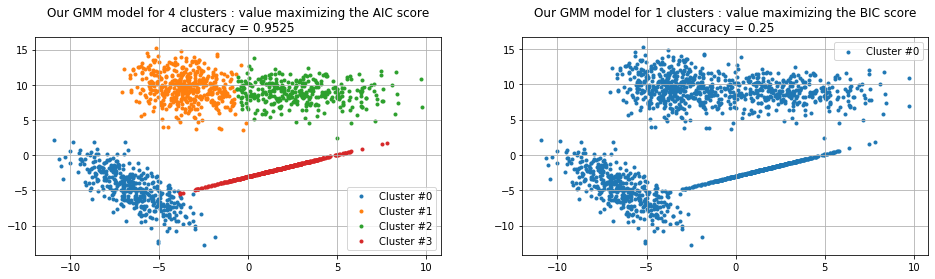

In [181]:
plt.figure(figsize=(16,4))

best_aic_gmm = my_GMM(k=np.argmax(AIC_scores)+1)
best_aic_gmm.fit(data)
best_bic_gmm = my_GMM(k=np.argmax(BIC_scores)+1)
best_bic_gmm.fit(data)

visualize_gmm(X, gmm1=best_aic_gmm, gmm2=best_bic_gmm, 
              title1='Our GMM model for {} clusters : value maximizing the AIC score'.format(optimal_AIC), 
              title2='Our GMM model for {} clusters : value maximizing the BIC score'.format(optimal_BIC))

**Observation :**
- The AIC score is pretty good but doesn't always yield the value we want.
- The BIC score seems to be too aggressive and thus always find 1 as the optimal value to maximize it...


*Let's explore new ways of finding the best number of clusters parameter !*

### Merge criterions

###### Correlation coeffictients

- Implement the merge criterions 
    - Correlation coefficients
    - Measuring Error : merge si la likelihood est meilleure
    - Comparing the parameters : si mu et Sigma sont 'suffisamment proches' on merge les deux clusters

In [274]:
def merge(merge_1, merge_2, X, gmm):
    cpm = gmm.cond_prob_
    alpha = gmm.alpha_
    mu = gmm.mu_
    Sigma = gmm.Sigma_
    # Update the cpm matrix
    cpm[:,merge_1] = cpm[:,merge_1] + cpm[:,merge_2]
    cpm = np.delete(cpm, merge_2, axis=1)
    # Update alpha
    alpha[merge_1] = alpha[merge_1] + alpha[merge_2]
    alpha = np.delete(alpha, merge_2)
    # Update mu
    mu = gmm.update_mu(X, cpm, alpha)
    # Update Sigma
    Sigma = gmm.update_Sigma(X, cpm, alpha, mu)
    
    k = gmm.k_ - 1
    
    return alpha, mu, Sigma, k

In [281]:
def correlation_coefficients(X, C_max=None):
    """
    Return the good number of clusters according to a low inter-cluster correlation criterion.
    """
    if C_max == None:
        C_max = X.shape[0]
    
    ### First, let's create the clusters using the value of C_max
    gmm = my_GMM(k=C_max)
    gmm.fit(X)
    alpha = gmm.alpha_
    mu = gmm.mu_
    Sigma = gmm.Sigma_
    history = {'alpha':[alpha], 'mu':[mu], 'Sigma':[Sigma], 
               'log_likelihood':[gmm.log_likelihood(X, alpha, mu, Sigma)]}
    
    ### Then, let's merge the too highly correlated clusters
    converged = False
    while not converged and gmm.k_ > 1:
        
        coefs = np.triu(np.corrcoef(gmm.cond_prob_, rowvar=False), 1)
        corr = np.amax(coefs)
        print(corr)
        
        if np.isnan(corr) or corr <= 0:
            converged = True
        else:
            merge_1, merge_2 = list(zip(*np.where(coefs == corr)))[0]
            alpha, mu, Sigma, k = merge(merge_1, merge_2, X, gmm)
            gmm.k_ = k
            gmm.fit_(X, alpha, mu, Sigma)
            # Update gmm
            
            # Keep track of the values
            history['alpha'].append(gmm.alpha_)
            history['mu'].append(gmm.mu_)
            history['Sigma'].append(gmm.Sigma_)
            history['log_likelihood'].append(gmm.log_likelihood(X, gmm.alpha_, gmm.mu_, gmm.Sigma_))

    return gmm, history

0.7859909477404272
0.6110057291280785
0.596599592524529
0.4687703038858983
0.23112281197751416
0.18326523795838512
0.0
[0 1 2 3]


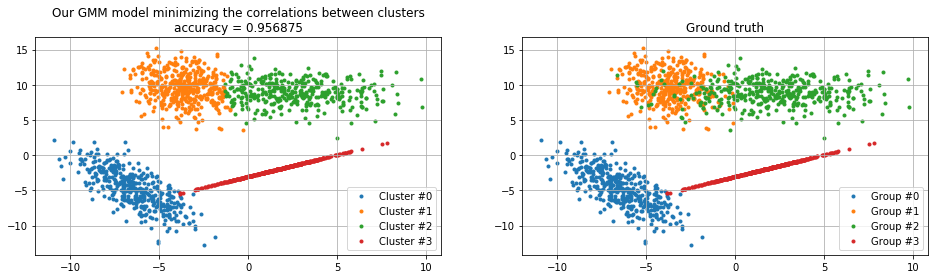

In [282]:
model_best_corr, history = correlation_coefficients(X=data, C_max=10)
print(np.unique(model_best_corr.labels_))
visualize_gmm(X, model_best_corr, 'Our GMM model minimizing the correlations between clusters')

   -> *Some weird results, we have to rethink our approach : maybe the correlations must be coputed on sth else than the cpm ?*

###### Measuring error

In [291]:
def measuring_error(X, C_max=None):
    """
    Return the good number of clusters according to a low likelihood criterion.
    """
    if C_max == None:
        C_max = X.shape[0]
    
    ### First, let's create the clusters using the value of C_max
    gmm = my_GMM(k=C_max)
    gmm.fit(X)
    history = gmm.history
    history['log_likelihood'] = [gmm.log_likelihood(X, gmm.alpha_, gmm.mu_, gmm.Sigma_)]
    
    ### Then, let's merge the clusters if it increases the likelihood
    converged = False
    while not converged and gmm.k_ > 1:
        
        old_lieklihood = history['log_likelihood'][-1]
        best_lieklihood = history['log_likelihood'][-1]
        #print('Best : ', best_lieklihood)
        
        # iteratively select two clusters and compute the potential new likelihood if we merge them
        for merge_1 in range(1, gmm.k_):
            for merge_2 in range(merge_1):
                new_alpha, new_mu, new_Sigma, new_k = merge(merge_1, merge_2, X, gmm)
                new_gmm = my_GMM(k=new_k)
                new_gmm.fit_(X, new_alpha, new_mu, new_Sigma)
                new_likelihood = new_gmm.log_likelihood(X, new_gmm.alpha_, new_gmm.mu_, new_gmm.Sigma_)
                #print('Current :', new_likelihood)
                if new_likelihood > best_lieklihood:
                    best_lieklihood = new_likelihood
                    best_gmm = new_gmm
        
        gmm = best_gmm
        
        if best_lieklihood==old_lieklihood:
            converged = True
        else:
            # Update gmm
            # Keep track of the values
            history['alpha'].append(best_gmm.alpha_)
            history['mu'].append(best_gmm.mu_)
            history['Sigma'].append(best_gmm.Sigma_)
            history['log_likelihood'].append(best_lieklihood)
            
    return gmm, history

In [ ]:
model_best_like, history = measuring_error(X=data, C_max=10)
print(np.unique(model_best_like.labels_))
visualize_gmm(X, model_best_like, 'Our GMM model maximizing the likelihood')

###### Comparing the parameters

In [ ]:
def compare_params(X, C_max=None):
    """
    Return the good number of clusters by merging the ones having similar mu and Sigma.
    """
    if C_max == None:
        C_max = X.shape[0]
    
    ### First, let's create the clusters using the value of C_max
    gmm = my_GMM(k=C_max)
    gmm.fit(X)
    alpha = gmm.alpha_
    mu = gmm.mu_
    Sigma = gmm.Sigma_
    history = {'alpha':[alpha], 'mu':[mu], 'Sigma':[Sigma], 
               'log_likelihood':[gmm.log_likelihood(X, alpha, mu, Sigma)]}
    
    ### Then, let's merge the clusters if it increases the likelihood
    converged = False
    while not converged and gmm.k_ > 1:
        
        old_lieklihood = history['log_likelihood'][-1]
        best_lieklihood = history['log_likelihood'][-1]
        print('Best : ', best_lieklihood)
        
        # iteratively select two clusters and compute the potential new likelihood if we merge them
        for merge_1 in range(1,gmm.k_):
            for merge_2 in range(merge_1):
                new_alpha, new_mu, new_Sigma = merge(merge_1, merge_2, X, gmm)
                new_likelihood = gmm.log_likelihood(X, new_alpha, new_mu, new_Sigma)
                print('Current :', new_likelihood)
                if new_likelihood > best_lieklihood:
                    best_lieklihood = new_likelihood
                    best_alpha, best_mu, best_Sigma = new_alpha, new_mu, new_Sigma
                    
        if best_lieklihood==old_lieklihood:
            converged = True
        else:
            # Update gmm
            gmm.k_, gmm.alpha_, gmm.mu_, gmm.Sigma_ = gmm.k_-1, best_alpha, best_mu, best_Sigma
            gmm.cond_prob_ = gmm.compute_proba(X, best_alpha, best_mu, best_Sigma)
            gmm.labels_ = gmm.predict(X, best_alpha, best_mu, best_Sigma)
            # Keep track of the values
            history['alpha'].append(alpha)
            history['mu'].append(mu)
            history['Sigma'].append(Sigma)
            history['log_likelihood'].append(gmm.log_likelihood(X, alpha, mu, Sigma))
            
    return gmm, history

### Cross-validation 

In [ ]:
# TODO

### Conclusion

Use the model selection criterions to choose the number of clusters for the two given datasets (data-MM-i.csv). Compare the results and the computational time. Try to visually validate your results.

In [ ]:
# TODO

# Application

You are going to work with the following data:

shape: (1797, 64)


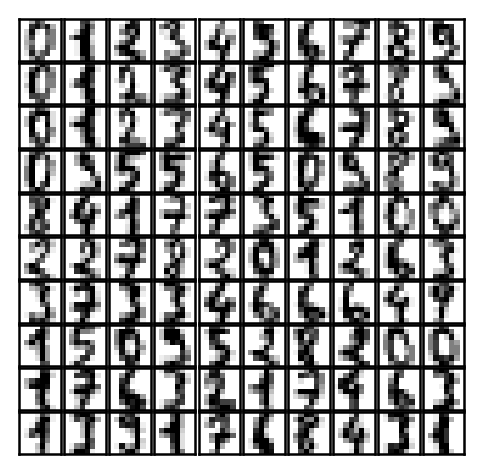

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method to produce new synthetic handwritten numbers. Explain why you used that model selection method in this case. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [ ]:
# TODO